In [6]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload
from oe_acute import MNE2
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)
import noisereduce as nr
#from noisereduce.noisereduce import reduce_noise

os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import syncutil as su
from ceciestunepipe.util import wavutil as wu
logger.info('all modules loaded')

2023-12-12 14:45:53,005 root         INFO     all modules loaded
2023-12-12 14:45:53,005 root         INFO     all modules loaded


## Load Bird Data - change date and bird name!

In [7]:
reload(et)
bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)


sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probe': 'probe_0',
           'sort': 'sort_0'}


exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']
sess_epochs = et.list_sgl_epochs(sess_par)

2023-12-12 14:45:53,634 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/scratch/

In [8]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch
sess_par['sort'] = 'sort_0'

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [9]:
bout_dict_path = os.path.join(exp_struct['folders']['sort'], 'bout_dict_ap0.pkl')
logger.info('Loading manually curated bout metadata from {}'.format(bout_dict_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)

2023-12-12 14:45:54,251 root         INFO     Loading manually curated bout metadata from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0/bout_dict_ap0.pkl
2023-12-12 14:45:54,251 root         INFO     Loading manually curated bout metadata from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0/bout_dict_ap0.pkl


In [10]:
wav_mic_path = exp_struct['files']['wav_mic']
logger.info('loading the microphone wav file ' + exp_struct['files']['wav_mic'])
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

2023-12-12 14:45:54,571 root         INFO     loading the microphone wav file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.wav
2023-12-12 14:45:54,571 root         INFO     loading the microphone wav file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.wav


In [11]:
logger.info('Will load cluster, spike dataframes from ' + exp_struct['folders']['sort'])

2023-12-12 14:45:54,899 root         INFO     Will load cluster, spike dataframes from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0
2023-12-12 14:45:54,899 root         INFO     Will load cluster, spike dataframes from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0


In [12]:
clu_df_path = os.path.join(exp_struct['folders']['sort'], 'clu_df.pkl')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
spk_df = pd.read_pickle(spk_df_path)

In [13]:
clu_df.head()

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
3,3,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 15, 19, 14, 13, 16, 21, 12, 25, 18, 22, 2...",17,"[13, 14, 15, 16, 17, 19, 21]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
5,5,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 21, 19, 20, 18, 16, 15, 22, 23, 25, 13, 1...",17,"[15, 16, 17, 18, 19, 20, 21]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
6,6,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[18, 16, 14, 20, 19, 12, 15, 24, 21, 17, 22, 2...",18,"[12, 14, 15, 16, 18, 19, 20]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
15,15,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[26, 28, 30, 24, 31, 22, 27, 23, 34, 32, 29, 2...",26,"[22, 24, 26, 27, 28, 30, 31]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
26,26,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[32, 30, 34, 35, 31, 36, 28, 33, 26, 24, 38, 3...",32,"[28, 30, 31, 32, 34, 35, 36]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra


In [14]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0'])

In [15]:
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr

def collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = bout_dict['s_f_ap_0']
    s_f_wav = bout_dict['s_f']
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(s_f_ap* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(s_f_ap * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(s_f_wav * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(s_f_wav * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr

In [16]:
s_f_wav = bout_dict['s_f']
print(s_f_wav)

20000


In [17]:
s_f_ap = bout_dict['s_f_ap_0']
print(s_f_ap)

30000.08851535173


In [18]:
#example of how to filter the units
# lists of clusters: good, mua, all together
clu_list_ra_good = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

clu_list_ra_mua = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

clu_list_ra_all = np.unique(clu_df.loc[(clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])
#clu_list = np.unique(clu_df['cluster_id'])

In [19]:
clu_list = clu_list_ra_all

spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = 0 # window starts some time previous to detected bout onset (seconds)
t_post = 0 # window ends soometime posterior to detected bout offset (seconds)

## get the bouts arrays into a bout_dict
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    clu_id_arr_list.append(np.array(clu_list))
    
bout_dict['t_pre_ms'] = t_pre * 1000
bout_dict['t_post_ms'] = t_post * 1000

bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list
print(len(clu_list))

<ipython-input-15-cb514117b64c>:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


186


In [20]:
# if you must make into a pandas dataframe
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)
bout_df['bout_id'] = bout_df['start_sample_nidq']

bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id
0,315996,474011,36545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1230, -1236, -1267, -1327, -1432, -1523, -16...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",315996
1,1297683,1946586,29620,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-457, -308, -409, -362, -419, -365, -421, -37...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",1297683
2,2223770,3335758,35175,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2076, 2095, 2154, 2300, 2460, 2653, 2568, 229...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",2223770
3,3801849,5702947,26205,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1977, -1761, -1568, -1718, -1950, -2203, -25...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",3801849
4,5677824,8516994,29050,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[936, 815, 735, 674, 680, 759, 832, 954, 1081,...","[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",5677824


## Visualizing Input Spectrograms 

In [21]:
from oe_acute import MNE2

s_f_ap =  int(bout_dict['s_f_ap_0'])
ms_bin_size = int(0.001 * s_f_ap)

nums = bout_df.shape[0]
spike_responses_all = []
spectrograms_all = []
stim_names = [] 
clusters = list(range(bout_df.iloc[1]['spk_arr'].shape[0]))
cluster_ratings = [1] * bout_df.iloc[1]['spk_arr'].shape[0]
#mic_fs = int(bout_dict['s_f'])
mic_fs = 25000 #change this to be what you want everything to be


def bin_spikes_ls(spk_arr, spk_len, n_bins_tgt):
    spike_clusters, spike_times = np.nonzero(spk_arr)
    fractional_spike_times = spike_times / spk_len
    spike_bins = (fractional_spike_times * n_bins_tgt).astype(np.int)
    sxx_binned_spikes = np.zeros((spk_arr.shape[0], n_bins_tgt), dtype=np.int)
    sxx_binned_spikes[spike_clusters, spike_bins] = 1
    return sxx_binned_spikes

for x in range(nums):
    single_spk_arr_temp = bout_df.iloc[x]['spk_arr']
    mic_to_sxx = MNE2.preprocess_sig_Kozlov(bout_df.iloc[x]['mic_arr'], fs_orig=25000)
    n_bins_tgt = mic_to_sxx.shape[1] # get number of spectrogram time bins
    #single_spk_arr_ms_temp = pu.coarse(single_spk_arr_temp, ms_bin_size)
    sxx_binned_spikes = bin_spikes_ls(single_spk_arr_temp, single_spk_arr_temp.shape[1], n_bins_tgt)[..., np.newaxis]
    spike_responses_all.append(sxx_binned_spikes)
    spectrograms_all.append(np.copy(mic_to_sxx))
    stim_names.append(np.copy(bout_df.iloc[x]['bout_id']))
    
    # Bird Parameters
bird = sess_par['bird']
sess = sess_par['sess']
probe = sess_par['probe']
sort = sess_par['sort']

# Number of jackknives to use during fitting
n_jackknives = 2

### Stimulus segment params
nsegbins = 16

### Spectrogram Averaging params
avg_nrows = 2
avg_ncols = 3

### Normalization params
radius = 10  # Project stimulus segments to sphere of <radius> radius
stim_zscore_thresh = 30

# number of stimulus dimensions (16 x 16)
n_dim = 256

print(f"shape of first spectrogram: {spectrograms_all[0].shape[0]} frequency bins, {spectrograms_all[0].shape[1]} time bins")
print(f"shape of first spike train: {spectrograms_all[0].shape[0]} cells, {spectrograms_all[0].shape[1]} time bins")

shape of first spectrogram: 64 frequency bins, 10799 time bins
shape of first spike train: 64 cells, 10799 time bins


In [23]:
# Preprocess stimuli and extract response tensors
#high pass filter the spectrograms
spectrograms_all_HPF = []
for stim in spectrograms_all: 
    medians = np.median(stim)
    stim[[0,1]] = medians
    spectrograms_all_HPF.append(stim)
stim_names = stim_names #stim names = bout names 
stim_spectrograms = spectrograms_all_HPF
stim_responses = spike_responses_all #these are binned to same timepoints as spectrograms (cells, units, ?)
clusters = clusters #1-# of clusters
cluster_ratings = cluster_ratings #all 1s 
n_cells = len(clusters)

In [25]:
print(spike_responses_all[0].shape)
print(stim_spectrograms[0].shape)
type(stim_spectrograms[0])


(186, 10799, 1)
(64, 10799)


numpy.ndarray

In [27]:

# Preprocess stimuli and extract response tensors
stim_names = stim_names #stim names = bout names 
stim_spectrograms = spectrograms_all 
stim_responses = spike_responses_all #these are binned to same timepoints as spectrograms (cells, units, ?)
clusters = clusters #1-# of clusters
cluster_ratings = cluster_ratings #all 1s 
n_cells = len(clusters)

# fully shuffle each stimulus response tensor
fs_stim_responses = [MNE2.full_shuffle_response(x) for x in stim_responses]

# mask shuffle each stimulus response tensor
ms_stim_responses = [MNE2.mask_shuffle_response(x) for x in stim_responses]

# permute time bins across all stims, same for each trial
ps_stim_responses = MNE2.permute_all_stim_time_bins(stim_responses)

#####################################################

# different variations on the response
# just do original and shuffled responses
response_classes = [stim_responses, fs_stim_responses]

kozlov_stim_responses = [MNE2.kozlov_avg_stim_resp(stim_spectrograms, x, avg_nrows, avg_ncols) for x in response_classes]

stim_response_segments = [MNE2.segment_stim_resp(x[0], x[1], nsegbins=nsegbins, mode='forward') for x in kozlov_stim_responses]

stim_response_segments_reshape = [(MNE2.reshape_stim_segments(x[0]), x[1]) for x in stim_response_segments]

stim_resp_mne = [MNE2.preprocess_MNE(x[0], x[1], radius) for x in stim_response_segments_reshape]

stim_resp_mne_train_test = [MNE2.prepare_MNE_train_test_set(x[0], x[1]) for x in stim_resp_mne]


58502
58502


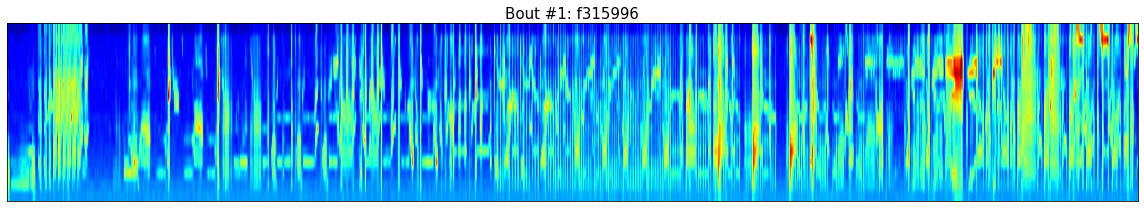

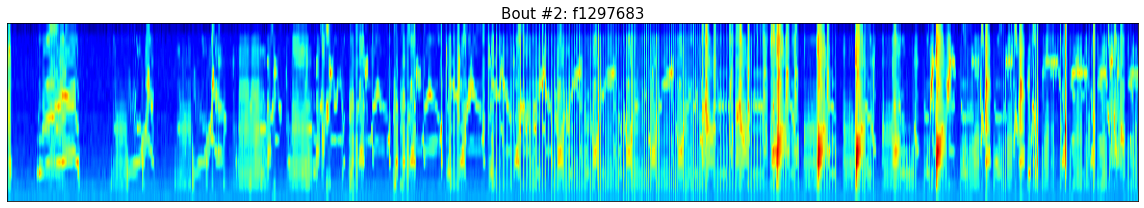

In [28]:
count = 0 
nums = (1,2)
for true_stim, stim_name, num in zip(kozlov_stim_responses[0][0], stim_names, nums):
    count += 1
    fig, axs = plt.subplots(1, 1, figsize=(16,3), sharex=True)
    axs.imshow(true_stim, cmap='jet', origin='lower', aspect='auto', interpolation=None)
    axs.set_title(f"Bout #{count}: f{stim_name}", fontsize=15)
    axs.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)
    plt.tight_layout()
    plt.show()

## getting the rasters

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

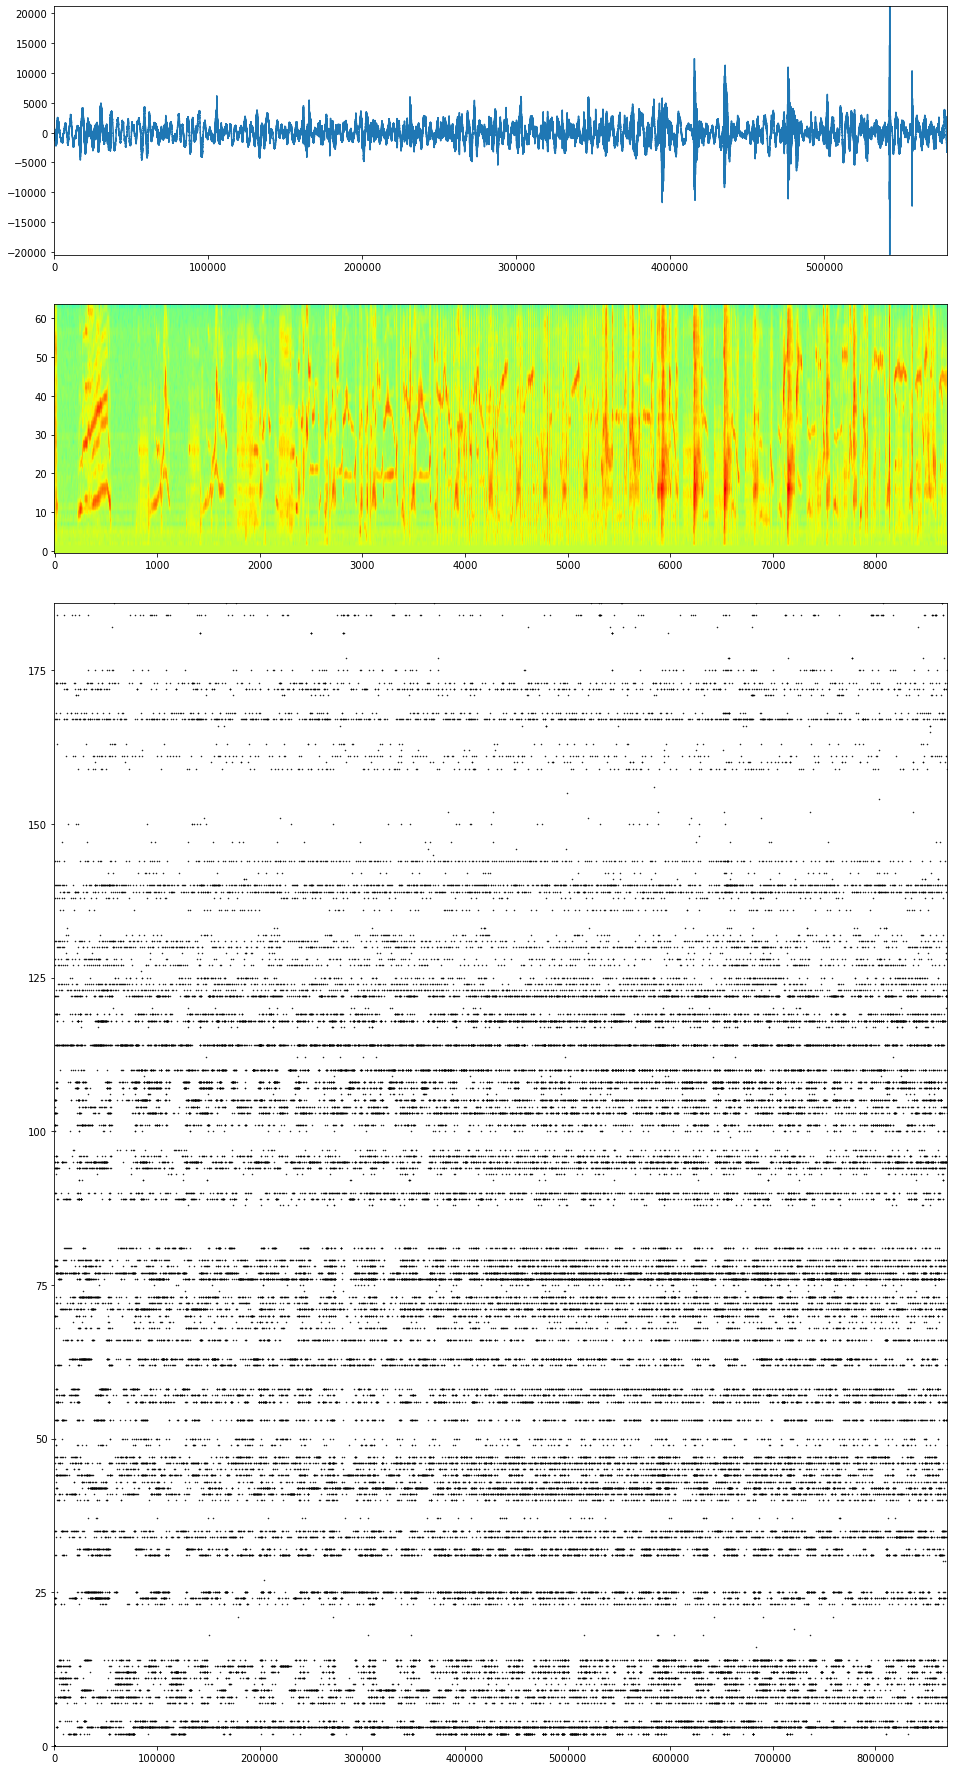

In [40]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
  #  x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax



def show_bout(bout_df, bout_id, stim_spectrograms, ax=None):
    bout_id_list = bout_df['bout_id']
    bout_id = bout_id_list[bout_id]
    if ax is None:
        fig = plt.figure(figsize=(16, 32))
        gs = fig.add_gridspec(6, 1)
        ax = []
        ax.append(fig.add_subplot(gs[0, :]))
        ax.append(fig.add_subplot(gs[1, :]))
        ax.append(fig.add_subplot(gs[2:, :]))
    bout_df['sxx'] = stim_spectrograms
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]    
    ax[0].plot(the_bout['mic_arr'].values[0])
    
    ax[1].imshow((the_bout['sxx'].values[0]), cmap='jet', origin='lower', aspect='auto', interpolation=None);
    
    plot_as_raster(the_bout['spk_arr'].values[0], ax=ax[2])
    #ax[2].imshow((the_bout['fr_arr'].values[0][::-1]), aspect='auto', cmap='inferno');
                           
    return ax

show_bout(bout_df, 1, stim_spectrograms)

In [ ]:
## full raster for whole time without the unspiking cells

#idenfiying the unspiking cells
testspiking = copy.deepcopy(the_bout['spk_arr'].values[0])
#print(testspiking.sum(axis=1))
#summing the spiking numbers over all songs 
testallspiking = copy.deepcopy(bout_df['spk_arr'])
#print(bout_id_list)
spikesum = []
for x in testallspiking:
    trialspikesum = x.sum(axis=1)
    spikesum.append(trialspikesum)
#idenfiying which cells over all songs have less than 10 spikes 
spikesoverall = sum(spikesum)
spikesoverall.shape
#print(spikesoverall)
morethan10 = spikesoverall > 10

#plot
bout_id = 1
bout_id_list = bout_df['bout_id']
bout_id = bout_id_list[bout_id]
bout_df['sxx'] = spectrograms_all
the_bout = bout_df.loc[bout_df['bout_id']==bout_id]  
#len_s = the_bout['len_ms'][1]/1000
#removing low spikers
allspikes = copy.deepcopy(the_bout['spk_arr'].values[0])
boutspikesoverall = allspikes.sum(axis=1)
morethanten = boutspikesoverall > 10
allspikes = allspikes[morethanten]

fig = plt.figure(figsize=(16, 32))
plt.rcParams['font.size'] = '38'
gs = fig.add_gridspec(6, 1)
ax = []
ax.append(fig.add_subplot(gs[0, :]))
ax.append(fig.add_subplot(gs[1, :]))
ax.append(fig.add_subplot(gs[2:, :]))   



ax[0].plot(the_bout['mic_arr'].values[0], color='black')
ax[0].set_axis_off()



ax[1].imshow((the_bout['sxx'].values[0]), cmap='jet', origin='lower', aspect='auto', interpolation=None);
y_len, x_len = the_bout['sxx'].values[0].shape
#ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_ticks(np.linspace(0, x_len, 5))
ax[1].xaxis.set_ticklabels(np.linspace(0, len_s, 5, dtype='int'))
ax[1].yaxis.set_ticks(np.linspace(0, y_len, 4))
ax[1].yaxis.set_ticklabels(np.linspace(0, 10, 4, dtype='int'))
ax[1].set_ylabel('f (kHz)')
# divthing = 42 
# subset1 = int(x_len1/divthing)
# ax[1].vlines(x = subset1*30 , ymin = 0, ymax = y_len1-1, colors = 'black')
# ax[1].vlines(x = subset1*31 , ymin = 0, ymax = y_len1-1, colors = 'black')




plot_as_raster(allspikes, ax=ax[2])
y_len2, x_len2 = allspikes.shape
#ax[2].get_xaxis().set_visible(False)
ax[2].set_ylabel('RA unit')
ax[2].xaxis.set_ticks(np.linspace(0, x_len2, 5))
ax[2].xaxis.set_ticklabels(np.linspace(0, len_s, 5, dtype='int'))
ax[2].set_xlabel('time (s)')
#subset2 = int(x_len2/divthing)
# ax[2].vlines(x = subset2*30 , ymin = 0, ymax = y_len2-1, colors = 'black')
# ax[2].vlines(x = subset2*31 , ymin = 0, ymax = y_len2-1, colors = 'black')

plt.tight_layout(pad=0.5)
#plt.savefig('/mnt/cube/lstanwic/paper_figures/fig1/startrasterb1253_614.png', dpi=300, bbox_inches='tight')